In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import entropy
import time

import gspread
from google.oauth2.service_account import Credentials


In [6]:
# Path to your service account JSON file
SERVICE_ACCOUNT_FILE = "../velvety-tube-450516-r5-2dfa430c056c.json" 


# Define the scope (Google Sheets + Google Drive API)
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive.file",  # Allows access to files the service account has access to
    "https://www.googleapis.com/auth/drive.readonly"  # Read-only access to drive files
]
# Authenticate with Google
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

# Open the spreadsheet
SPREADSHEET_NAME = "sparse_parity_21_4"
spreadsheet = client.open(SPREADSHEET_NAME)




In [9]:
# Get names of all sheets
sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]
name_to_idx = {}
for i, name in enumerate(sheet_names):
    name_to_idx[name] = i
print("Sheets in the spreadsheet:", sheet_names)

# transformer_template = 'SAN_sparse_parity_k4_nbits21_n2000_bf{}_seed1234'
# rnn_template = 'RNN_sparse_majority_k5_nbits21_n2000_bf{}_seed1234'
# bf_vals = list(range(0, 50, 5))
bf_vals = [0, 1, 2, 5, 10, 20]
best_n = 1
df_dct = {
    # "RNN": {} 
    "SAN": {}
            }

best_dct = {
    # "RNN": {"noiseless": [], "noisy": []}, 
    "SAN": {"noiseless": [], "noisy": []}
            }

for k in best_dct.keys():
    sheetname_template = '{}_sparse_parity_k4_nbits21_n5000_bf{}_seed1234'
    for bf in bf_vals:
        target = sheetname_template.format(k, bf)
        target_idx = name_to_idx.get(target)
        print("Loading:", target)
        if target_idx is None:
            raise ValueError(f"Sheet {target} not found.")
        sheet = spreadsheet.get_worksheet(target_idx)
        data = sheet.get_all_records()
        df = pd.DataFrame(data)
        df_dct[k][bf] = df
        best_noiseless = df.sort_values(by='val_acc', ascending=False).head(best_n)['noiseless_val_acc'].to_numpy()
        best_noisy = df.sort_values(by='val_acc', ascending=False).head(best_n)['val_acc'].to_numpy()
        best_dct[k]["noiseless"].append(best_noiseless)
        best_dct[k]["noisy"].append(best_noisy)



Sheets in the spreadsheet: ['SAN_sparse_parity_k4_nbits21_n5000_bf1_seed1234', 'SAN_sparse_parity_k4_nbits21_n5000_bf2_seed1234', 'SAN_sparse_parity_k4_nbits21_n5000_bf5_seed1234', 'RNN_sparse_parity_k4_nbits21_n5000_bf0_seed1234', 'RNN_sparse_parity_k4_nbits21_n5000_bf10_seed1234', 'RNN_sparse_parity_k4_nbits21_n5000_bf20_seed1234', 'SAN_sparse_parity_k4_nbits21_n5000_bf0_seed1234', 'SAN_sparse_parity_k4_nbits21_n5000_bf10_seed1234', 'SAN_sparse_parity_k4_nbits21_n5000_bf20_seed1234']
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf0_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf1_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf2_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf5_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf10_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf20_seed1234


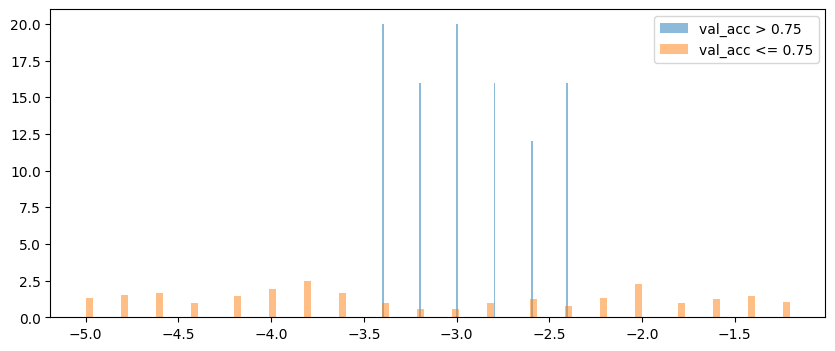

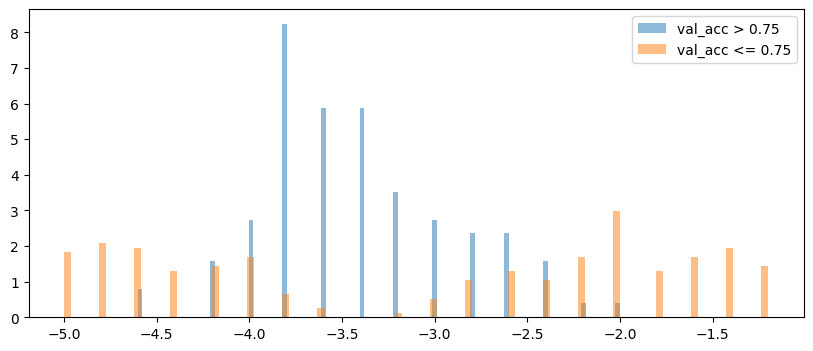

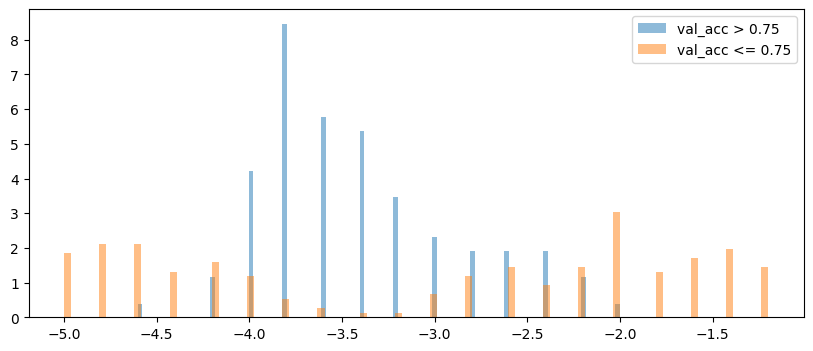

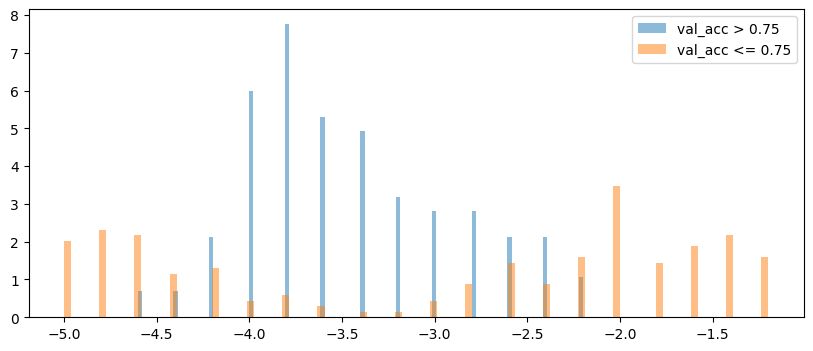

In [19]:
for bf in [0, 1, 2, 5]:
    df_bf0 = df_dct["SAN"].get(bf)
    # plot the val_acc versus lr
    gt_75 = df_bf0[df_bf0['val_acc'] > 0.75]
    lt_75 = df_bf0[df_bf0['val_acc'] <= 0.75]
    fig, ax = plt.subplots(figsize=(10, 4))    
    ax.hist(np.log10(gt_75['lr']), bins=100, alpha=0.5, label='val_acc > 0.75', density=True)
    ax.hist(np.log10(lt_75['lr']), bins=100, alpha=0.5, label='val_acc <= 0.75', density=True)
    ax.legend()
    print()


In [5]:

all_H = []
all_mle = []
p_bitflips = [bf / 100 for bf in bf_vals]
def sparity_k4(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    """Wrapper for sparse_parity_k_n with k=4"""
    return make_datasets.sparse_parity_k_n(n_bits, 4, n_data, p_bitflip, seed, subseq_idx=subseq_idx)

# Generate data with bitflip values
seed = 1234 
n_data = 1000000 # ~maximum~ amount of data to analyze
inc = 50000 # increment at which to check convergence
assert inc < n_data
n_bits = 5 # HACK: We only consider the bits that actually contribute to the majority vote
intermediate_idx = list(range(inc, n_data, inc))

all_H = []
all_mle_noisy = []
all_mle_noiseless = []

for i in range(len(p_bitflips)):
    t0 = time.time()
    X, Z, idx = sparity_k4(n_data, n_bits, p_bitflips[i], seed)
    print("generated data for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    t0 = time.time()
    # compute the mle performance and the mle lookup table for this dataset
    H_results, mle_results, lookup_results = entropy.empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
    print("computed entropy for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_H.append(H_results)
    all_mle_noisy.append(mle_results)
    # compute the accuracy of MLE(trained on noisy) predicting the noiseless data
    t0 = time.time()
    mle_noiseless = entropy.compute_mle_with_lookup(X, lookup_results[-1])
    print("computed noiseless MLE for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_mle_noiseless.append(mle_noiseless)

generated data for p_bitflip =  0.0  took  5.204999208450317  seconds
computed entropy for p_bitflip =  0.0  took  1.9409997463226318  seconds
computed noiseless MLE for p_bitflip =  0.0  took  2.7679998874664307  seconds
generated data for p_bitflip =  0.1  took  5.166028261184692  seconds
computed entropy for p_bitflip =  0.1  took  1.96799898147583  seconds
computed noiseless MLE for p_bitflip =  0.1  took  2.5940003395080566  seconds
generated data for p_bitflip =  0.2  took  5.217965841293335  seconds
computed entropy for p_bitflip =  0.2  took  2.0600357055664062  seconds
computed noiseless MLE for p_bitflip =  0.2  took  2.848994016647339  seconds


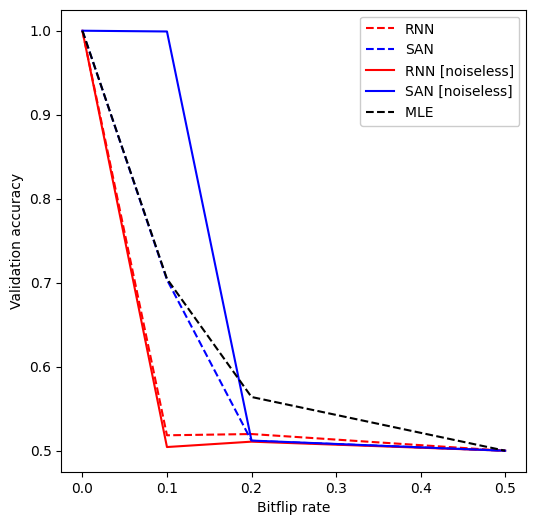

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
def append_last(x, y):
    return np.concatenate((x, [0.5])).flatten(), np.concatenate((y, [0.5])).flatten()

if best_n == 1:
    rnn_noiseless = np.array(best_dct["RNN"]["noiseless"]).flatten()
    rnn_noisy = np.array(best_dct["RNN"]["noisy"]).flatten()
    san_noiseless = np.array(best_dct["SAN"]["noiseless"]).flatten()
    san_noisy = np.array(best_dct["SAN"]["noisy"]).flatten()

    axes.plot(*append_last(p_bitflips, rnn_noisy), label='RNN', c='r', ls='--')
    axes.plot(*append_last(p_bitflips, san_noisy), label='SAN', c='b', ls='--')
    axes.plot(*append_last(p_bitflips, rnn_noiseless), label='RNN [noiseless]', c='r', ls='-')
    axes.plot(*append_last(p_bitflips, san_noiseless), label='SAN [noiseless]', c='b', ls='-')

else:
    axes.plot(np.repeat(bf, best_n), best_dct["RNN"]["noiseless"][i], label='RNN', c='r', marker='o', s=15)
    axes.plot(np.repeat(bf, best_n), best_dct["SAN"]["noiseless"][i], label='SAN', c='b', marker='o', s=15)
    axes.plot(np.repeat(bf, best_n), best_dct["RNN"]["noisy"][i], label='RNN', c='r', marker='x', s=15)
    axes.plot(np.repeat(bf, best_n), best_dct["SAN"]["noisy"][i], label='SAN', c='b', marker='x', s=15)

# plot the noiseless mle by hand

mle_noisy_final = np.array([x[-1] for x in all_mle_noisy])
axes.plot(*append_last(p_bitflips, mle_noisy_final), label='MLE ', c='k', ls='--')
# axes.plot([0, 0.5, 0.5], [1, 1, 0.5], label='MLE [noiseless]', c='k', ls='-')
leg_prop = {'size': 10}
axes.legend(prop=leg_prop, framealpha=1)
axes.set_xlabel('Bitflip rate')
axes.set_ylabel('Validation accuracy')
print()
# axes.plot(np.repeat(bf_vals, best_n), best_dct["RNN"].flatten(), axis=1, label='RNN')
# axes.plot(np.repeat(bf_vals, best_n), best_dct["SAN"].flatten(), axis=1, label='SAN')

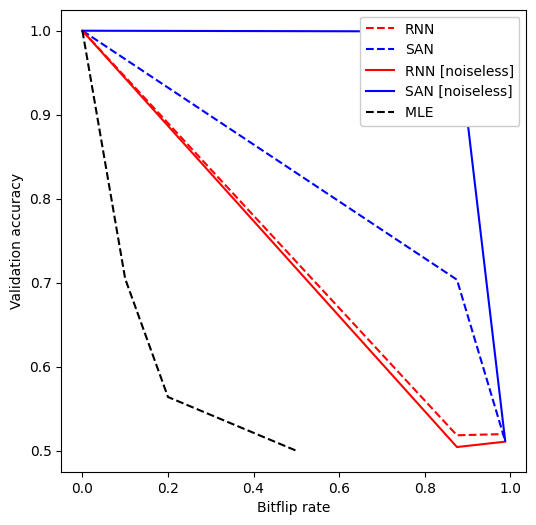

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
def append_last(x, y):
    return np.concatenate((x, [0.5])).flatten(), np.concatenate((y, [0.5])).flatten()

H_x = [x[-1] for x in all_H]
if best_n == 1:
    rnn_noiseless = np.array(best_dct["RNN"]["noiseless"]).flatten()
    rnn_noisy = np.array(best_dct["RNN"]["noisy"]).flatten()
    san_noiseless = np.array(best_dct["SAN"]["noiseless"]).flatten()
    san_noisy = np.array(best_dct["SAN"]["noisy"]).flatten()

    axes.plot(H_x, rnn_noisy, label='RNN', c='r', ls='--')
    axes.plot(H_x, san_noisy, label='SAN', c='b', ls='--')
    axes.plot(H_x, rnn_noiseless, label='RNN [noiseless]', c='r', ls='-')
    axes.plot(H_x, san_noiseless, label='SAN [noiseless]', c='b', ls='-')

else:
    axes.plot(np.repeat(bf, best_n), best_dct["RNN"]["noiseless"][i], label='RNN', c='r', marker='o', s=15)
    axes.plot(np.repeat(bf, best_n), best_dct["SAN"]["noiseless"][i], label='SAN', c='b', marker='o', s=15)
    axes.plot(np.repeat(bf, best_n), best_dct["RNN"]["noisy"][i], label='RNN', c='r', marker='x', s=15)
    axes.plot(np.repeat(bf, best_n), best_dct["SAN"]["noisy"][i], label='SAN', c='b', marker='x', s=15)

# plot the noiseless mle by hand

mle_noisy_final = np.array([x[-1] for x in all_mle_noisy])
axes.plot(*append_last(p_bitflips, mle_noisy_final), label='MLE ', c='k', ls='--')
# axes.plot([0, 0.5, 0.5], [1, 1, 0.5], label='MLE [noiseless]', c='k', ls='-')
leg_prop = {'size': 10}
axes.legend(prop=leg_prop, framealpha=1)
axes.set_xlabel('Bitflip rate')
axes.set_ylabel('Validation accuracy')
print()
# axes.plot(np.repeat(bf_vals, best_n), best_dct["RNN"].flatten(), axis=1, label='RNN')
# axes.plot(np.repeat(bf_vals, best_n), best_dct["SAN"].flatten(), axis=1, label='SAN')